In [1]:
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyspark.sql.functions as fn
from pyspark.sql import SparkSession
from pyspark.sql.functions import count 
import warnings
import os

# Start A Spark Session

In [2]:
# Initialise a sparksession with Hive Store Support
warnings.filterwarnings('ignore')


spark = SparkSession.builder \
        .master('local[4]')\
        .enableHiveSupport()\
        .appName('Research_Notebook')\
        .config('spark.sql.execution.arrow.pyspark.enabled', True) \
        .config('spark.driver.memory','12G') \
        .config('spark.ui.showConsoleProgress', True) \
        .config('spark.sql.repl.eagerEval.enabled', True) \
        .config('spark.jars', '/home/jovyan/work/Downloads/spark-bigquery-with-dependencies_2.12-0.22.0.jar') \
        .getOrCreate()

21/11/26 13:38:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
spark

In [5]:
# Ensure ecommerce_logs database is selected

spark.sql("use ecommerce_logs")

""


# Load Data From BigQuery

In [6]:
# Load data from bigquery into database in Hive

def load_sessions_data():
    df = spark.read.format('bigquery') \
        .option("credentialsFile", "/home/jovyan/work/my-project-55555-327612-b044a507aca8.json")\
        .option('parentProject','my-project-55555-327612') \
        .option('table', 'my-project-55555-327612.Research_data.research_project_data')\
        .load()
    
    return df 
df = load_sessions_data()

In [7]:
# Display 3 rows in the views data

df.limit(3).toPandas()

,fullVisitorId,visitId,date,bounces,sessionsPerDay,transactions,totalTransactionRevenue,pageviews,sessionQualityDim,hits,...,pagePath,productName,productCategory,pageLoadTime,action_type,browser,productListPosition,v2ProductCategory,productClicks,target
0,9343672387826743904,1484226289,20170112,1,1,NaN,NaN,1,NaN,1,...,/asearch.html,None,None,NaN,0,Safari,4,(not set),NaN,NaN
1,4208671726226413638,1484275099,20170112,1,1,NaN,NaN,1,NaN,1,...,/google+redesign/bags,None,None,NaN,0,Chrome,3,Home/Bags/,NaN,NaN
2,4208671726226413638,1484275099,20170112,1,1,NaN,NaN,1,NaN,1,...,/google+redesign/bags,None,None,NaN,0,Chrome,7,Home/Bags/,NaN,NaN


# Check the Schema of the Data

In [8]:

df.printSchema()

root
 |-- fullVisitorId: string (nullable = true)
 |-- visitId: long (nullable = true)
 |-- date: string (nullable = true)
 |-- bounces: long (nullable = true)
 |-- sessionsPerDay: long (nullable = true)
 |-- transactions: long (nullable = true)
 |-- totalTransactionRevenue: long (nullable = true)
 |-- pageviews: long (nullable = true)
 |-- sessionQualityDim: long (nullable = true)
 |-- hits: long (nullable = true)
 |-- timeOnSite: long (nullable = true)
 |-- pagePath: string (nullable = true)
 |-- productName: string (nullable = true)
 |-- productCategory: string (nullable = true)
 |-- pageLoadTime: long (nullable = true)
 |-- action_type: string (nullable = true)
 |-- browser: string (nullable = true)
 |-- productListPosition: long (nullable = true)
 |-- v2ProductCategory: string (nullable = true)
 |-- productClicks: long (nullable = true)
 |-- target: long (nullable = true)



In [10]:
# Save sessions data to hive table

df.write.format("ORC").saveAsTable("db_ecommerceData")

21/11/26 00:22:54 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
21/11/26 00:22:54 WARN HiveConf: HiveConf of name hive.internal.ss.authz.settings.applied.marker does not exist
21/11/26 00:22:54 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
21/11/26 00:22:54 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist


In [11]:
# Count the sessions records 
spark.sql("select count(*) as Count from db_ecommerceData").show()

+-------+
|  Count|
+-------+
|6401239|
+-------+



In [11]:
# Count the views records

spark.sql("select count(*) as Count from db__session").show()

+-------+
|  Count|
+-------+
|8130442|
+-------+



# Initial Visualization and Analysis of the Data

In [12]:
# Create a spark dataframe from hive table

df = spark.sql("SELECT * FROM db_ecommerceData")

In [ ]:
# Determine Sessions with highest timeOnSite

In [6]:
# Show number of views per day

sql = """
        SELECT
          date,
          COUNT(fullVisitorId) AS sessions,
          SUM(transactions) AS transactions
        FROM
          db_ecommerceData
        GROUP BY
          date
        ORDER BY
          date
      """

pageviews_per_day = spark.sql(sql).toPandas()
pageviews_per_day

,date,sessions,transactions
0,20170101,19272,1372
1,20170102,21400,965
2,20170103,27649,2584
3,20170104,39701,2478
4,20170105,32512,2771
...,...,...,...
208,20170728,32519,2524
209,20170729,24477,1135
210,20170730,27287,1281
211,20170731,38092,3458


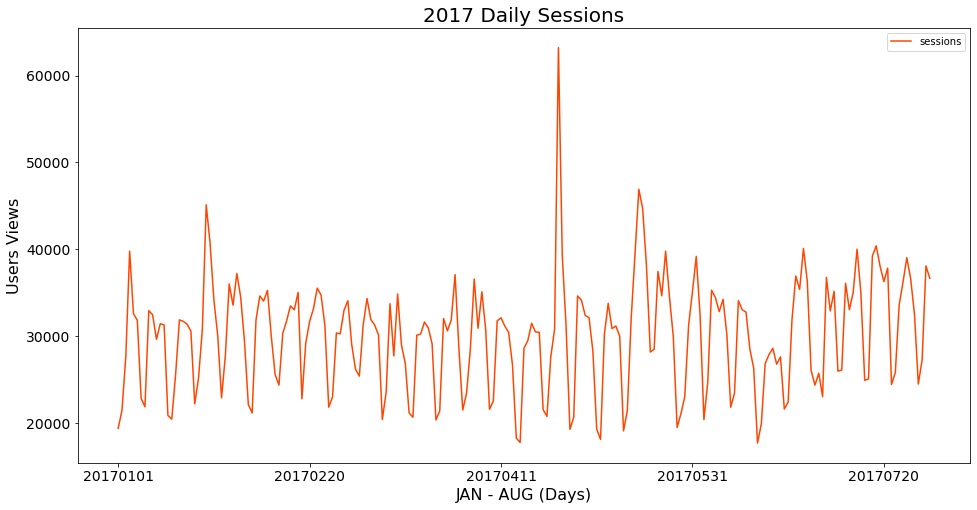

In [36]:
pageviews_per_day_df = pd.DataFrame(pageviews_per_day)
pageviews_per_day_df.set_index('sessions')
color = ['orangered']

pageviews_per_day_plot = pageviews_per_day_df.plot(figsize = (16, 8), kind='line', x="date", y="sessions", color=color)
plt.xlabel("JAN - AUG (Days)", fontsize = 16)
plt.ylabel("Users Views", fontsize = 16)
plt.title("2017 Daily Sessions", fontsize = 20, color = 'k')
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show()

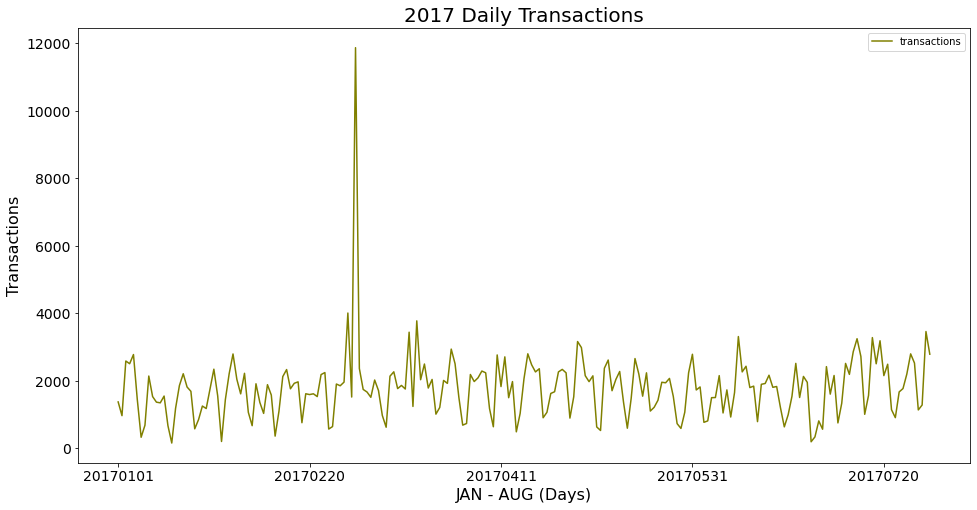

In [37]:
pageviews_per_day_df = pd.DataFrame(pageviews_per_day)
pageviews_per_day_df.set_index('sessions')
color = ['olive']

pageviews_per_day_plot = pageviews_per_day_df.plot(figsize = (16, 8), kind='line', x="date", y="transactions", color=color)
plt.xlabel("JAN - AUG (Days)", fontsize = 16)
plt.ylabel("Transactions", fontsize = 16)
plt.title("2017 Daily Transactions", fontsize = 20, color = 'k')
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show()

In [ ]:
# Show user sessions with top transactions and total revenue 

sql = """
        SELECT
          DISTINCT fullVisitorId AS users,
          SUM(totals.transactions) AS transactions,
          SUM(totals.transactions) / COUNT(*) AS conversion_rate,
          SUM(totals.totalTransactionRevenue) / 1000000 AS total_revenue
        FROM
          db_ecommerce
        GROUP BY
          fullVisitorId
        ORDER BY
          transactions DESC
        LIMIT
          10  
      """
users_transaction_revenue = spark.sql(sql).toPandas()
users_transaction_revenue

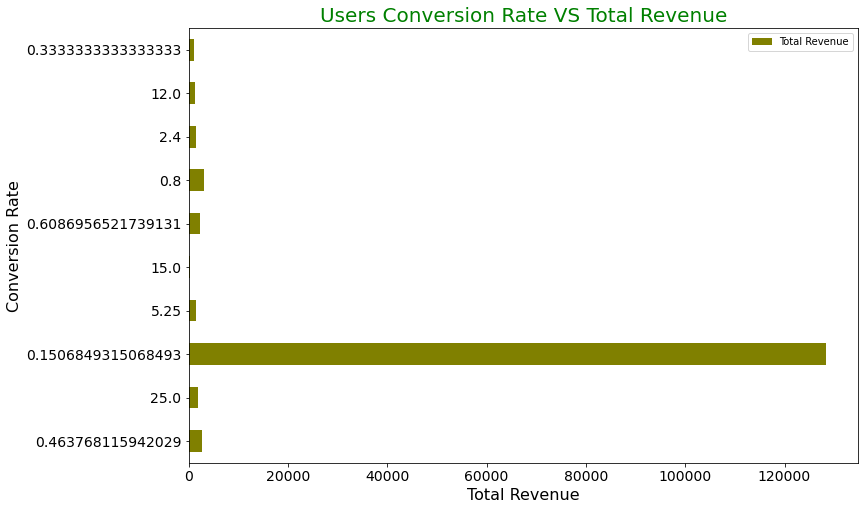

In [258]:
# Visualize 

users_transaction_revenue_df = pd.DataFrame(users_transaction_revenue)
conversion_rate = users_transaction_revenue['conversion_rate']
total_revenue = users_transaction_revenue['total_revenue']
conversion_revenue = {'Conversion Rate': conversion_rate, 'Total Revenue': total_revenue}
conversion_revenue_df = pd.DataFrame.from_dict(conversion_revenue)

conversion_revenue_plot = conversion_revenue_df.plot(figsize = (12, 8), kind='barh', x='Conversion Rate', y='Total Revenue', color="olive")
plt.xlabel("Total Revenue", fontsize = 16)
plt.ylabel("Conversion Rate", fontsize = 16)
plt.title("Users Conversion Rate VS Total Revenue", fontsize = 20, color = 'g')
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show()

In [ ]:
sql = """
        SELECT
          COUNT(DISTINCT fullVisitorId) AS sessions,
          userTransactions,
          date
        FROM
          db_data
        GROUP BY
          userTransactions,
          date
        ORDER BY
          date
      """
transactions = spark.sql(sql).toPandas()
transactions_df = pd.DataFrame(transactions)
transactions_df.set_index('sessions')
color = ['orangered']

transactions_plot = transactions_df.plot(figsize = (16, 8), kind='line', x="date", y="userTransactions", color=color)
plt.xlabel("JAN - AUG (Days)", fontsize = 16)
plt.ylabel("Users Transactions", fontsize = 16)
plt.title("2017 Daily Sessions", fontsize = 20, color = 'k')
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show()

In [137]:
# Determine user sessions with high Bounce Rate 

sql = """
        SELECT
          fullVisitorId AS users,
          visitId,
          COUNT(*) AS sessions,
          sum(totals.bounces) / COUNT(*) AS bounce_rate
        FROM
          db_ecommerce
        GROUP BY
          users,
          visitId
        ORDER BY
          bounce_rate DESC
        LIMIT
          10
      """
users_bounce_rate = spark.sql(sql)
users_bounce_rate

users,visitId,sessions,bounce_rate
1464118866435322718,1493435952,1,1.0
7596855916472037617,1493614929,1,1.0
7549458195494611096,1492758019,1,1.0
0297018420074101211,1487724682,1,1.0
4714714555902550257,1490479887,1,1.0
7660377708313228942,1484754662,1,1.0
7035044035659755870,1491068552,1,1.0
3431362306097214306,1487167739,1,1.0
6475984486122752415,1487321937,1,1.0
436486178014637646,1498216835,1,1.0


In [132]:
# Determine Users with high Exit Rate

sql = """
        SELECT
          fullVisitorId AS users,
          visitId,
          COUNT(*) AS views,
          SUM(totals.bounces) / COUNT(*) AS exit_rate
        FROM
          db_ecommerce
        GROUP BY
          users,
          visitId
        ORDER BY
          exit_rate ASC
        LIMIT
          10
      """
users_exit_rate = spark.sql(sql)
users_exit_rate

users,visitId,views,exit_rate
6604862402043138486,1494799463,1,null
9148167346814274414,1496698379,1,null
9609104828919391966,1495838816,1,null
9446297351559825194,1493497352,1,null
9387513564437162701,1491685757,1,null
2486238973615425743,1483627716,1,null
0575917765333661923,1490266145,1,null
9924165574549418396,1488703977,1,null
25404210472994637,1487335476,1,null
7972147770200170376,1488337753,1,null


In [98]:
# determine the traffic type, quality and transactions and revenue

sql = """
        SELECT
          trafficSource.medium,
          COUNT(*) AS sessions,
          SUM(totals.bounces) / COUNT(*) AS exit_rate,
          SUM(totals.transactions) AS transactions,
          SUM(totals.totalTransactionRevenue) / 1000000 AS total_revenue,
          SUM(totals.transactions) / COUNT(*) AS conversion_rate
        FROM
          db_ecommerce
        GROUP BY
          medium
        ORDER BY
          total_revenue DESC
      """
traffic_quality = spark.sql(sql)
traffic_quality

medium,sessions,exit_rate,transactions,total_revenue,conversion_rate
(none),189445,0.43964211248647367,4697,716676.81,0.024793475678956952
organic,173428,0.5145305256359988,1496,146596.91,0.008626058075973891
cpm,3226,0.37414755114693116,90,121005.71,0.027898326100433975
referral,82023,0.6179364324640649,180,23344.29,0.002194506418931...
cpc,9265,0.38672423097679437,176,20732.75,0.01899622234214787
affiliate,9761,0.5699211146398935,6,558.67,6.14691117713349E-4
(not set),112,0.44642857142857145,1,11.99,0.008928571428571428


In [40]:
# Show the action type count 

sql = """
      SELECT 
      CASE 
         WHEN action_type = '1' THEN 'Click through of product lists'
         WHEN action_type = '2' THEN 'Product detail views'
         WHEN action_type = '5' THEN 'Check out'
         WHEN action_type = '6' THEN 'Completed purchase'
         ELSE 'Other action types'
      END AS action_types,
      COUNT(*) AS views
      FROM db_ecommerceData
      GROUP BY action_types
      ORDER BY views ASC
      """
action_type = spark.sql(sql).toPandas()
action_type

,action_types,views
0,Completed purchase,11101
1,Check out,45789
2,Product detail views,128457
3,Click through of product lists,133571
4,Other action types,6082321


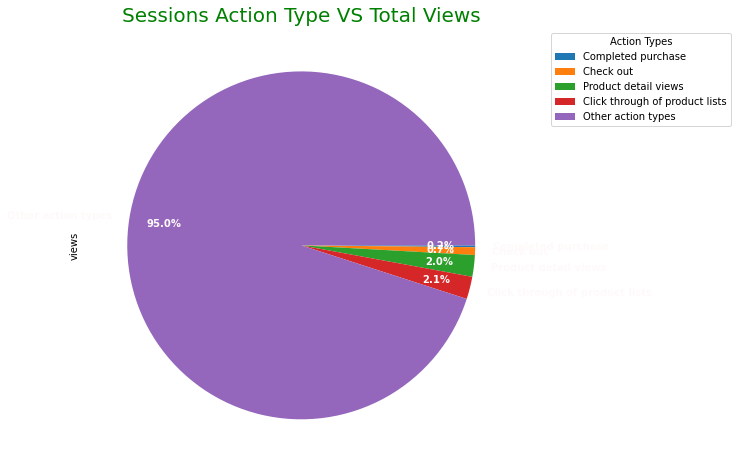

In [41]:
action_type_df = pd.DataFrame(action_type)
action_type_df.set_index('action_types', inplace=True)


explode = (0, 0.1, 0, 0)
action_type_plot = action_type_df.plot(figsize = (12, 8), kind='pie', autopct='%1.1f%%',x="action_types",pctdistance=0.8,textprops=dict(color="snow", weight="bold"), y="views",counterclock=False)
plt.legend(title="Action Types", loc="upper right", bbox_to_anchor=(1, 0, 0.5, 1))
plt.title("Sessions Action Type VS Total Views", fontsize = 20, color = 'g')
plt.show()

In [60]:
# Show and Visualise the total revenue for month 

sql = """
        SELECT
          CASE
            WHEN date BETWEEN '20170801'
            AND '20170831' THEN 'August'
            WHEN date BETWEEN '20170701'
            AND '20170731' THEN 'July'
            WHEN date BETWEEN '20170601'
            AND '20170630' THEN 'June'
            WHEN date BETWEEN '20170501'
            AND '20170531' THEN 'May'
            WHEN date BETWEEN '20170401'
            AND '20170430' THEN 'April'
            WHEN date BETWEEN '20170301'
            AND '20170331' THEN 'March'
            WHEN date BETWEEN '20170201'
            AND '20170228' THEN 'February'
            WHEN date BETWEEN '20170101'
            AND '20170131' THEN 'January'
          END AS 2017_sessions,
          CASE
            WHEN date BETWEEN '20170801'
            AND '20170831' THEN 8
            WHEN date BETWEEN '20170701'
            AND '20170731' THEN 7
            WHEN date BETWEEN '20170601'
            AND '20170630' THEN 6
            WHEN date BETWEEN '20170501'
            AND '20170531' THEN 5
            WHEN date BETWEEN '20170401'
            AND '20170430' THEN 4
            WHEN date BETWEEN '20170301'
            AND '20170331' THEN 3
            WHEN date BETWEEN '20170201'
            AND '20170228' THEN 2
            WHEN date BETWEEN '20170101'
            AND '20170131' THEN 1
          END AS monthly_sessions,
          COUNT(*) AS sessions,
          SUM(totals.totalTransactionRevenue) / 1000000 AS monthly_revenue
        FROM
          db_ecommerce
        GROUP BY
          2017_sessions,
          monthly_sessions
        ORDER BY
          monthly_sessions
      """
monthly_revenue = spark.sql(sql).toPandas()
monthly_revenue

,2017_sessions,monthly_sessions,sessions,monthly_revenue
0,January,1,64694,106248.15
1,February,2,62192,116111.60
2,March,3,69931,150224.70
3,April,4,67126,222767.98
4,May,5,65371,135952.00
5,June,6,63578,127992.84
6,July,7,71812,160739.86
7,August,8,2556,8890.00


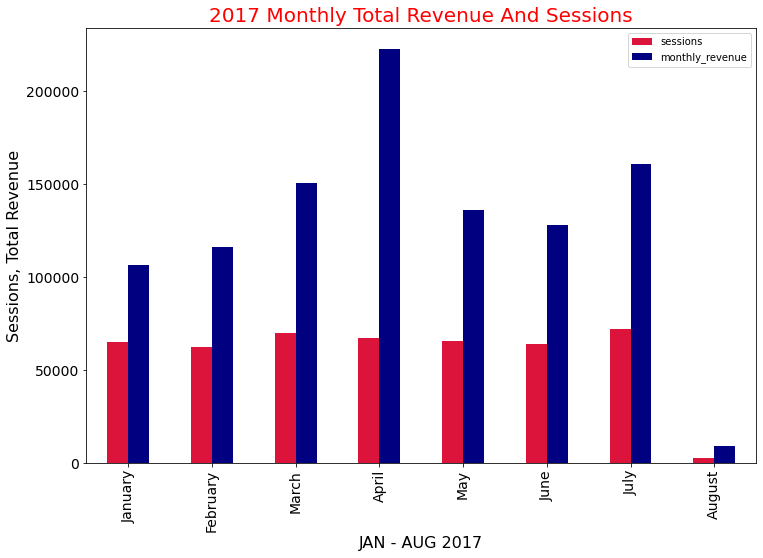

In [61]:
monthly_revenue_df = pd.DataFrame(monthly_revenue)
monthly_revenue_df.set_index('2017_sessions')
color = ['crimson', 'navy']

monthly_revenue_plot = monthly_revenue_df.plot(figsize = (12, 8), kind='bar', x="2017_sessions", y=["sessions","monthly_revenue"], color=color)
plt.xlabel("JAN - AUG 2017", fontsize = 16)
plt.ylabel("Sessions, Total Revenue", fontsize = 16)
plt.title("2017 Monthly Total Revenue And Sessions", fontsize = 20, color = 'r')
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show()

In [51]:
# Show and visualise popular pages and their bounce rate

sql = """
        SELECT
          pagePath as landing_page,
          COUNT(*) as views,
          SUM(totals.bounces) / COUNT(*) AS bounce_rate
        FROM
          db__session s
          INNER JOIN db_ecommerce e ON s.fullVisitorId = e.fullVisitorId
        WHERE
          s.hitNumber = 1
          AND s.type = 'PAGE'
        AND 
          e.fullVisitorId == s.fullVisitorId
        AND
          e.visitId == s.visitId
        GROUP BY
          landing_page
        ORDER BY
          views DESC
        LIMIT
          10
      """

popular_pages = spark.sql(sql).toPandas()
popular_pages

,landing_page,views,bounce_rate
0,/google+redesign/shop+by+brand/youtube,796705,0.578232
1,/google+redesign/apparel/mens/mens+t+shirts,150384,0.475662
2,/google+redesign/apparel/men++s/men++s+t+shirts,66504,0.468964
3,/google+redesign/bags,61176,0.469988
4,/google+redesign/drinkware,58344,0.573427
5,/google+redesign/apparel,47496,0.433805
6,/google+redesign/apparel/headgear,32603,0.538999
7,/google+redesign/electronics,32208,0.560730
8,/google+redesign/apparel/men++s/men++s+outerwear,30588,0.440957
9,/google+redesign/accessories/stickers/home,28013,0.501124


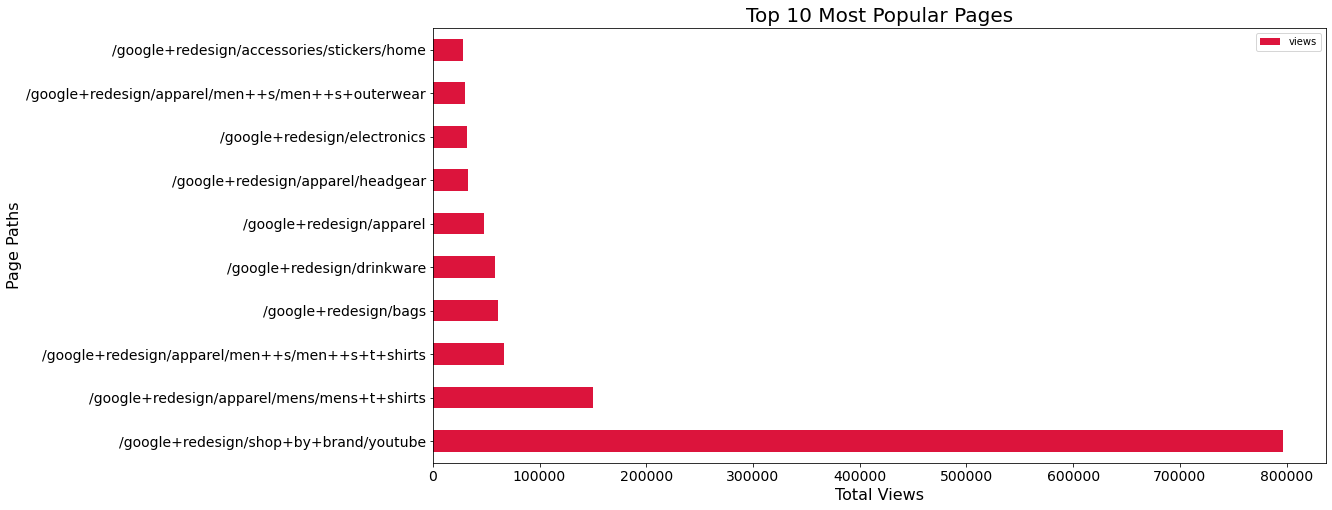

In [52]:
# Show and visualise bounce rate of pages

popular_pages_df = pd.DataFrame(popular_pages)
popular_pages_df.set_index('landing_page')
color = ['crimson']

popular_pages_plot = popular_pages_df.plot(figsize = (16, 8), kind='barh', x="landing_page", y="views", color=color)
plt.xlabel("Total Views", fontsize = 16)
plt.ylabel("Page Paths", fontsize = 16)
plt.title("Top 10 Most Popular Pages", fontsize = 20, color = 'k')
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show()

In [49]:
# Analyse and compare action type with products and transactions

sql = """
        SELECT
          DISTINCT v2productName AS products,
          SUM(e.totals.transactions) AS complete_transactions,
          action_type
        FROM
          db__session s
          INNER JOIN db_ecommerce e ON e.fullVisitorId = s.fullVisitorId
        WHERE
          action_type == "6"
        AND 
          e.fullVisitorId == s.fullVisitorId
        AND
          e.visitId == s.visitId
        GROUP BY
          action_type,
          v2productName
        ORDER BY
          complete_transactions DESC
        LIMIT
          10
      """

products_transactions = spark.sql(sql).toPandas()
products_transactions

,products,complete_transactions,action_type
0,Google Sunglasses,1688,6
1,Google 22 oz Water Bottle,961,6
2,Google Men's 100% Cotton Short Sleeve Hero Tee...,890,6
3,BLM Sweatshirt,870,6
4,Google Men's 100% Cotton Short Sleeve Hero Tee...,864,6
5,Google Laptop and Cell Phone Stickers,804,6
6,Google Men's Vintage Badge Tee Black,754,6
7,Gift Card - $25.00,614,6
8,Recycled Paper Journal Set,608,6
9,Google Men's 100% Cotton Short Sleeve Hero Tee...,606,6


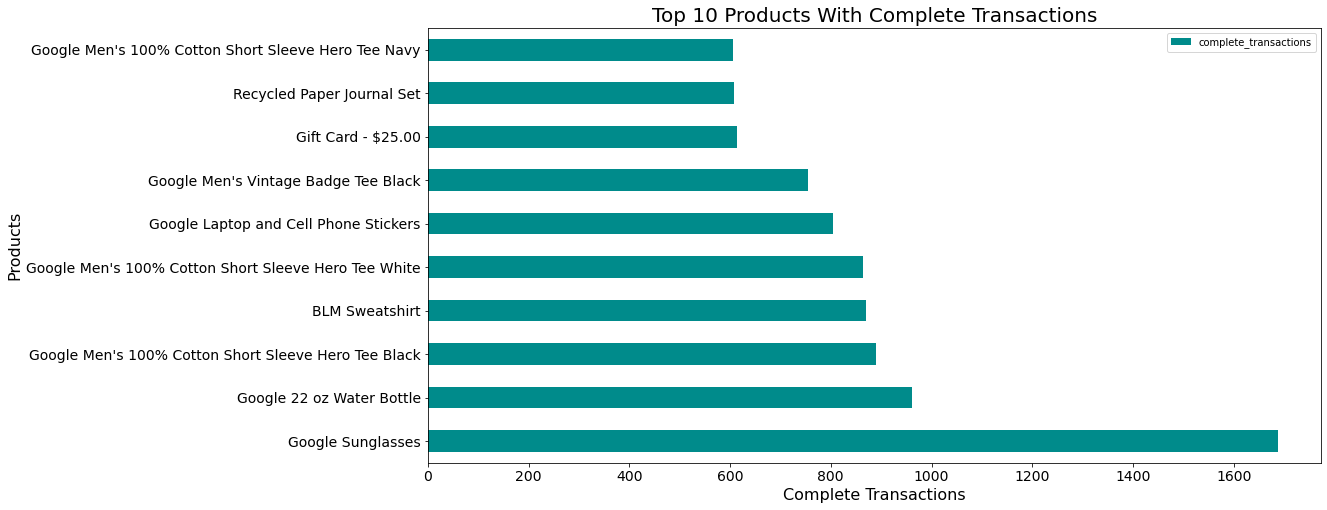

In [50]:
products_transactions_df = pd.DataFrame(products_transactions)
products_transactions_df.set_index('products')
color = ['darkcyan']

products_transactions_plot = products_transactions_df.plot(figsize = (16, 8), kind='barh', x="products", y="complete_transactions", color=color)
plt.xlabel("Complete Transactions", fontsize = 16)
plt.ylabel("Products", fontsize = 16)
plt.title("Top 10 Products With Complete Transactions", fontsize = 20, color = 'k')
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show()

In [453]:
# Determine device browser bounce rate

sql = """
        SELECT
          device.browser as user_browser,
          COUNT(device.browser) AS browser_count,
          SUM(totals.bounces) / COUNT(*) AS bounce_rate
        FROM
          db_ecommerce
        GROUP BY
          user_browser
        ORDER BY
          browser_count DESC
        LIMIT
          10
      """
browsers_bounce_rate = spark.sql(sql).toPandas()
browsers_bounce_rate

,user_browser,browser_count,bounce_rate
0,Chrome,331324,0.474557
1,Safari,75598,0.512289
2,Firefox,20705,0.626467
3,Internet Explorer,11094,0.646295
4,Android Webview,7134,0.572470
5,Edge,5993,0.573502
6,Safari (in-app),4780,0.602510
7,Opera Mini,3736,0.695931
8,Opera,2376,0.595539
9,UC Browser,1647,0.676988


In [9]:
# Identify Top 10 Countries with most sessions
sql = """
      SELECT geoNetwork.country as country,
             COUNT(*) AS sessions_country_count
      FROM db_ecommerce
      GROUP BY country
      ORDER BY sessions_country_count DESC
      LIMIT 10
      """

country_count = spark.sql(sql).toPandas()
country_count

,country,sessions_country_count
0,United States,206188
1,India,29249
2,United Kingdom,23248
3,Canada,14805
4,Germany,12252
5,Japan,11461
6,France,9754
7,Australia,7783
8,Taiwan,7737
9,Spain,7423
